In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Helper functions

# Calculate average weighted sum aoi
def average_weighted_sum_aoi(d_i_k, M, K, alpha_i):
    I_i = [set() for w in range(M)] # set of inter-delivery times
    h_avg_i = np.zeros(M) # per-node time-average AoI
    J_avg = 0 # average weighted sum AoI
    
    for y in range(M):
        delivery_times = np.nonzero(d_i_k[y])[0] + 1
    
        # Add inter-delivery times to set
        last_delivery = 0
        for d_t in delivery_times:
            id_t = d_t - last_delivery
            I_i[y].add(id_t)
            last_delivery = d_t
            
            # AoI calculations
            h_avg_i[y] += ((id_t + 1)*id_t) / (2*K)
            
        # Add remaining slots to set
        rs_t = K - last_delivery
        I_i[y].add(rs_t)
    
        # AoI calculations
        h_avg_i[y] += ((rs_t + 1)*rs_t) / (2*K)
        J_avg += alpha_i[y]*h_avg_i[y]/M
        
    return J_avg

# Temporal Evolution

In [3]:
# Model parameters
M = 15
epsilon = 0.9
V = V_prime = 1
i = np.arange(start=1, stop=M+1)
alpha_i = (M + 1 - i)/M
p_i = i/M
q_i = epsilon*p_i/M

In [4]:
# Run optimization for R*
gamma_i = alpha_i*p_i/(M*q_i**2)
gamma = np.max(gamma_i)
mu_i = q_i/p_i * np.max(np.concatenate((np.ones((M,1)), np.reshape(np.sqrt(gamma_i/gamma), (M, 1))), axis=1), axis=1)
S = np.sum(mu_i)
while S < 1:
    gamma -= 0.1
    mu_i = q_i/p_i * np.max(np.concatenate((np.ones((M,1)), np.reshape(np.sqrt(gamma_i/gamma), (M, 1))), axis=1), axis=1)
    S = np.sum(mu_i)
mu_i = np.round(mu_i, 4)

In [5]:
# Run optimization for WI
chi_i = alpha_i*p_i*((1/q_i)**2 - (1/p_i - 1/2)**2)/2
C = np.max(chi_i)
phi_i_inv = p_i*np.sqrt(2*np.min(np.concatenate((C*np.ones((M,1)), np.reshape(chi_i, (M, 1))), axis=1), axis=1) / (alpha_i*p_i) + (1/p_i - 1/2)**2)
S = np.sum(1/phi_i_inv)

while S < 1:
    C -= 0.1
    phi_i_inv = p_i*np.sqrt(2*np.min(np.concatenate((C*np.ones((M,1)), np.reshape(chi_i, (M, 1))), axis=1), axis=1) / (alpha_i*p_i) + (1/p_i - 1/2)**2)
    S = np.sum(1/phi_i_inv)
    
C_star = C
chi_i_star = np.min(np.concatenate((C_star*np.ones((M,1)), np.reshape(chi_i, (M, 1))), axis=1), axis=1)
theta_i = C_star - chi_i_star

In [6]:
# Repeated calculations
alpha_times_p_i = 0.5*alpha_i*p_i
alpha_div_mu_i = 0.5*alpha_i/mu_i
two_div_p_i = 2/p_i

In [7]:
# Simulation parameters
K_values = np.array([10**4, 5*10**4, 10**5, 5*10**5, 10**6, 15*10**6])
G_values = np.ceil(10**8/K_values)
G_values = np.min(np.concatenate((np.reshape(G_values, (1,6)), 100*np.ones((1,6))), axis=0), axis=0).astype(int) # Exceeding 100 sims would take too long to run, so set 1000 as the upper bound

In [8]:
np.sum(G_values[0:1]*K_values[0:1])

1000000

In [9]:
np.sum(G_values*K_values)

271000000

In [10]:
G_values

array([100, 100, 100, 100, 100,   7])

In [11]:
G_values = np.array([100, 80, 60, 30, 10, 1])

In [12]:
np.sum(G_values*K_values)

51000000

In [13]:
# Initialize AoI and throughput debt vectors
R_Star_aoi = np.zeros_like(G_values)
R_Star_tpd = np.zeros_like(G_values)
MW_aoi = np.zeros_like(G_values)
MW_tpd = np.zeros_like(G_values)
DPP_aoi = np.zeros_like(G_values)
DPP_tpd = np.zeros_like(G_values)
WI_aoi = np.zeros_like(G_values)
WI_tpd = np.zeros_like(G_values)

In [14]:
# For each value of G, run all simulations g number of times
for sim_size in range(6):
    G = G_values[sim_size]
    K = K_values[sim_size]

    ## R* ##
    for z in range(G):
        # Sample to determine which nodes will be scheduled in which slot
        i_k = stats.rv_discrete(a=1, b=M, values=(i, mu_i)).rvs(size=K)

        # Calculate transmission matrix that indiciates which node has an arrival in which slot
        d_i_k = np.zeros((M,K))

        # Efficient way to generate bernoulli samples for each time slot, rather than calling rvs function K times
        node_counts = np.unique(i_k, return_counts=True)[1]
        bernoulli_samples = dict()
        bernoulli_idx = dict()
        for node_idx in range(M):
            bernoulli_idx.update({node_idx : 0})
            bernoulli_samples.update({node_idx : stats.bernoulli.rvs(p=p_i[node_idx], size=node_counts[node_idx])})
        
        for x in range(K):
            node_k_idx = i_k[x]-1
            d_i_k[node_k_idx, x] = bernoulli_samples[node_k_idx][bernoulli_idx[node_k_idx]]
            bernoulli_idx[node_k_idx] += 1

        # Calculate average weighted sum AoI
        R_Star_aoi[sim_size] += average_weighted_sum_aoi(d_i_k, M, K, alpha_i)

    R_Star_aoi[sim_size] /= G
    print(f"Finished R* for G = {K_values[sim_size]}")
    
    ## MW ##
    for z in range(G):
        # Initialize transmission matrix that indiciates which node has an arrival in which slot
        d_i_k = np.zeros((M,K))
        d_i_k_sum = np.zeros(M)
        q_i_sum = np.zeros(M)
        
        # Initialize AoI and throughput debt vectors
        h_i = np.ones(M)
        x_i = np.zeros(M)
    
        # Efficiently generate enough Bernoulli samples for each node
        bernoulli_samples = np.zeros((M,K))
        for node_idx in range(M):
            bernoulli_samples[node_idx, :] = stats.bernoulli.rvs(p=p_i[node_idx], size=K)
        
        # Loop over slots
        for k in np.arange(1,K+1):
            # Select node according to policy
            W_i = alpha_times_p_i*(h_i**2+2*h_i) + V*p_i*np.where(x_i > 0, x_i, 0)
            i_sel = np.argmax(W_i)+1
            
            # Update transmission matrix based on whether transmission was successful or not
            d_i_k[i_sel-1, k-1] = bernoulli_samples[i_sel-1, k-1]
            
            # Update AoI and throughput debt vectors
            h_i += 1
            if d_i_k[i_sel-1, k-1] == 1: # if transmission was successful
                h_i[i_sel-1] = 1
            d_i_k_sum += d_i_k[:,k-1]
            q_i_sum += q_i
            x_i = q_i_sum - d_i_k_sum

        # Calculate average weighted sum AoI
        MW_aoi[sim_size] += average_weighted_sum_aoi(d_i_k, M, K, alpha_i)

    MW_aoi[sim_size] /= G
    print(f"Finished MW for G = {K_values[sim_size]}")

    ## DPP ##
    for z in range(G):
        # Initialize transmission matrix that indiciates which node has an arrival in which slot
        d_i_k = np.zeros((M,K))
        d_i_k_sum = np.zeros(M)
        q_i_sum = np.zeros(M)
        
        # Initialize AoI and throughput debt vectors
        h_i = np.ones(M)
        x_i = np.zeros(M)
    
        # Efficiently generate enough Bernoulli samples for each node
        bernoulli_samples = np.zeros((M,K))
        for node_idx in range(M):
            bernoulli_samples[node_idx, :] = stats.bernoulli.rvs(p=p_i[node_idx], size=K)
        
        # Loop over slots
        for k in np.arange(1,K+1):
            # Select node according to policy
            W_prime_i = alpha_div_mu_i*h_i + V_prime*p_i*np.where(x_i > 0, x_i, 0)
            i_sel = np.argmax(W_prime_i)+1
            
            # Update transmission matrix based on whether transmission was successful or not
            d_i_k[i_sel-1, k-1] = bernoulli_samples[i_sel-1,k-1]
            
            # Update AoI and throughput debt vectors
            h_i += 1
            if d_i_k[i_sel-1, k-1] == 1: # if transmission was successful
                h_i[i_sel-1] = 1
            d_i_k_sum += d_i_k[:,k-1]
            q_i_sum += q_i
            x_i = q_i_sum - d_i_k_sum

        # Calculate average weighted sum AoI
        DPP_aoi[sim_size] += average_weighted_sum_aoi(d_i_k, M, K, alpha_i)

    DPP_aoi[sim_size] /= G
    print(f"Finished DPP for G = {K_values[sim_size]}")

    ## WI ##
    for z in range(G):
        # Initialize transmission matrix that indiciates which node has an arrival in which slot
        d_i_k = np.zeros((M,K))
        d_i_k_sum = np.zeros(M)
        q_i_sum = np.zeros(M)
        
        # Initialize AoI and throughput debt vectors
        h_i = np.ones(M)
        x_i = np.zeros(M)
    
        # Efficiently generate enough Bernoulli samples for each node
        bernoulli_samples = np.zeros((M,K))
        for node_idx in range(M):
            bernoulli_samples[node_idx, :] = stats.bernoulli.rvs(p=p_i[node_idx], size=K)
        
        # Loop over slots
        for k in np.arange(1,K+1):
            # Select node according to policy
            C_i_h_i = alpha_times_p_i*(h_i**2 + two_div_p_i*h_i - h_i) + theta_i
            i_sel = np.argmax(C_i_h_i)+1
            
            # Update transmission matrix based on whether transmission was successful or not
            d_i_k[i_sel-1, k-1] = bernoulli_samples[i_sel-1,k-1]
            
            # Update AoI and throughput debt vectors
            h_i += 1
            if d_i_k[i_sel-1, k-1] == 1: # if transmission was successful
                h_i[i_sel-1] = 1
            d_i_k_sum += d_i_k[:,k-1]
            q_i_sum += q_i
            x_i = q_i_sum - d_i_k_sum

        # Calculate average weighted sum AoI
        WI_aoi[sim_size] += average_weighted_sum_aoi(d_i_k, M, K, alpha_i)

    WI_aoi[sim_size] /= G
    print(f"Finished WI for G = {K_values[sim_size]}")

Finished R* for G = 100
Finished MW for G = 100
Finished DPP for G = 100
Finished WI for G = 100
Finished R* for G = 80
Finished MW for G = 80
Finished DPP for G = 80
Finished WI for G = 80
Finished R* for G = 60
Finished MW for G = 60
Finished DPP for G = 60
Finished WI for G = 60
Finished R* for G = 30
Finished MW for G = 30
Finished DPP for G = 30
Finished WI for G = 30
Finished R* for G = 10
Finished MW for G = 10
Finished DPP for G = 10
Finished WI for G = 10
Finished R* for G = 1
Finished MW for G = 1
Finished DPP for G = 1
Finished WI for G = 1


Text(0, 0.5, 'Expected Weighted Sum AoI')

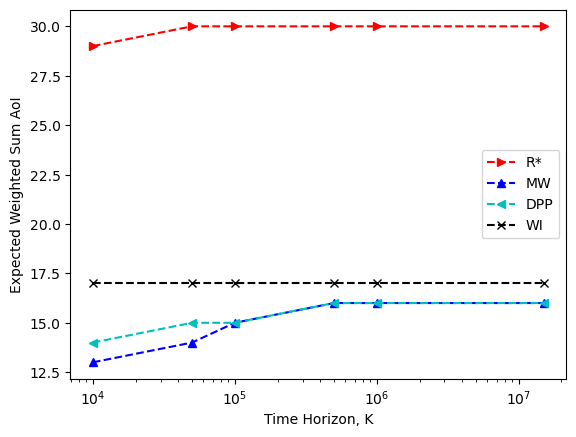

In [30]:
plt.figure()
plt.semilogx(K_values, R_Star_aoi, color='r', linestyle='dashed', label='R*', marker=">")
plt.semilogx(K_values, MW_aoi, color='b', linestyle='dashed', label='MW', marker="^")
plt.semilogx(K_values, DPP_aoi, color='c', linestyle='dashed', label='DPP', marker="<")
plt.semilogx(K_values, WI_aoi, color='k', linestyle='dashed', label='WI', marker="x")
plt.legend()
plt.xlabel("Time Horizon, K")
plt.ylabel("Expected Weighted Sum AoI")